# 衛星画像データ解析を始める前に

ここでは、

- ラスターデータとベクターデータ
- GeoPandasを利用してベクターデータの読み込みや描画
- csvデータとベクターデータの結合
- 参照系

について紹介します。

## GeoPandasを触ってみよう

[GeoPandas](https://geopandas.org)とはそもそも何なのか。GeoPandasとはPandasによるテーブルデータの処理と、Shapelyによる幾何学的なデータ処理を併せ持ったものになります。そこにmatplotlibによる描画支援も行われているため、地理空間情報を簡単なテーブルデータで処理できるだけでなく、ちょっとしたコマンドで直接描画まで行えるという優れものです。

![GeoDataFrame](https://geopandas.org/_images/dataframe.svg)

<center>Source: GeoPandas developers.</center>

言葉で説明するよりも、図で見るとわかりやすいです。地理空間情報は様々な形式がありますが、それを上図のようなテーブルにしてしまい、shapelyにより処理される幾何情報はgeometryという列に保存されています。このようなテーブルデータをGeoDataFrameと呼びます。

In [ ]:
# Colab利用時
# 解析に必須なライブラリのインストール
!apt install gdal-bin python-gdal python3-gdal 
# rtreeをインストール（GeoPandasで必要）
!apt install python3-rtree 
# GeoPandasのインストール
!pip install git+git://github.com/geopandas/geopandas.git
## Foliumをインストール（可視化用）
!pip install --upgrade folium
# plotlyのインストール
!pip install plotly-express
!pip install --upgrade plotly # ライブラリの更新
!pip install matplotlib-scalebar # 縮尺用のライブラリ
# geemapとipygeeをインストール
!pip install geemap
!pip install ipygee

In [ ]:
# Colab利用時には、まずKernelの再起動を行ってください
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
from datetime import datetime
import geemap
from ipygee import*
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.dpi'] = 300 # 解像度

データを使って実際に解析をしてみましょう。今回は、初婚の平均年齢を可視化してみましょう。

利用するデータはGithubからダウンロード可能です。
- [平均初婚年齢](https://github.com/sorabatake/article_20455_geopandas/blob/master/input/marriage.csv)
- [日本のシェープファイル](https://github.com/sorabatake/article_20455_geopandas/tree/master/input/japanSHP)

### 初婚年齢データの読み込み

In [ ]:
# colab利用時
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
marriageDf = pd.read_csv('/content/drive/MyDrive/marriage.csv')

データの中身を確認します。

In [ ]:
marriageDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cat01_code        680 non-null    int64  
 1   年齢(5歳階級)          680 non-null    object 
 2   cat02_code        680 non-null    int64  
 3   世帯の主な仕事           680 non-null    object 
 4   cat03_code        680 non-null    int64  
 5   総数・再掲             680 non-null    object 
 6   cat04_code        680 non-null    int64  
 7   夫・妻               680 non-null    object 
 8   area_code         680 non-null    int64  
 9   都道府県（特別区−指定都市再掲）  680 non-null    object 
 10  time_code         680 non-null    int64  
 11  時間軸(年次)           680 non-null    object 
 12  unit              680 non-null    object 
 13  value             680 non-null    float64
dtypes: float64(1), int64(6), object(7)
memory usage: 74.5+ KB


こちらは[e-stat](https://www.e-stat.go.jp/dbview?sid=0003413966)からダウロードしたものとなります。ダウンロード前にレイアウトを操作してからダウンロードしてありますが、それ以外に加工はしていません。そのため、ここでは簡単なデータクリーニングも含めて進めていきましょう。

In [ ]:
marriageDf.head()

,cat01_code,年齢(5歳階級),cat02_code,世帯の主な仕事,cat03_code,総数・再掲,cat04_code,夫・妻,area_code,都道府県（特別区−指定都市再掲）,time_code,時間軸(年次),unit,value
0,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2019000000,2019年,歳,30.8
1,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2018000000,2018年,歳,30.8
2,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2017000000,2017年,歳,30.8
3,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2016000000,2016年,歳,30.8
4,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2015000000,2015年,歳,30.7


In [ ]:
# カテゴリカル変数も含めて表示
marriageDf.describe(include='all')

,cat01_code,年齢(5歳階級),cat02_code,世帯の主な仕事,cat03_code,総数・再掲,cat04_code,夫・妻,area_code,都道府県（特別区−指定都市再掲）,time_code,時間軸(年次),unit,value
count,680.0,680,680.0,680,680.0,680,680.000000,680,680.000000,680,6.800000e+02,680,680,680.000000
unique,NaN,1,NaN,1,NaN,1,NaN,2,NaN,68,NaN,5,1,NaN
top,NaN,平均初婚年齢,NaN,総数,NaN,総数,NaN,夫,NaN,北海道,NaN,2019年,歳,NaN
freq,NaN,680,NaN,680,NaN,680,NaN,340,NaN,10,NaN,136,680,NaN
mean,80.0,NaN,100.0,NaN,100.0,NaN,105.000000,NaN,23430.588235,NaN,2.017000e+09,NaN,NaN,30.130441
std,0.0,NaN,0.0,NaN,0.0,NaN,5.003681,NaN,12992.852446,NaN,1.415255e+06,NaN,NaN,0.944747
min,80.0,NaN,100.0,NaN,100.0,NaN,100.000000,NaN,1000.000000,NaN,2.015000e+09,NaN,NaN,28.500000
25%,80.0,NaN,100.0,NaN,100.0,NaN,100.000000,NaN,13075.000000,NaN,2.016000e+09,NaN,NaN,29.200000
50%,80.0,NaN,100.0,NaN,100.0,NaN,105.000000,NaN,23050.000000,NaN,2.017000e+09,NaN,NaN,30.200000
75%,80.0,NaN,100.0,NaN,100.0,NaN,110.000000,NaN,34025.000000,NaN,2.018000e+09,NaN,NaN,30.900000


列名を変更します。

In [ ]:
marriageDf = marriageDf.loc[:,['夫・妻','都道府県（特別区−指定都市再掲）','時間軸(年次)','value']].\
rename(columns={'夫・妻':'sex','都道府県（特別区−指定都市再掲）':'prefecture','時間軸(年次)':'year','value':'avgAge'}).copy()

In [ ]:
marriageDf.sex = marriageDf.sex.replace('夫','male',regex=False).replace('妻','female',regex=False)
marriageDf.year = marriageDf.year.replace('年$','',regex=True)
# marriageDf.year = pd.to_datetime(marriageDf.year, format = '%Y').dt.to_period('y')
marriageDf.year = marriageDf.year.astype('int64')

includeStr = ['県$','道$','都$','府$']
marriageDf = marriageDf.loc[marriageDf.prefecture.str.contains('|'.join(includeStr)),:].reset_index(drop=True)

In [ ]:
marriageDf.describe(include='all') # describe all variables

,sex,prefecture,year,avgAge
count,470,470,470.00000,470.000000
unique,2,47,NaN,NaN
top,male,北海道,NaN,NaN
freq,235,10,NaN,NaN
mean,NaN,NaN,2017.00000,29.986809
std,NaN,NaN,1.41572,0.911568
min,NaN,NaN,2015.00000,28.500000
25%,NaN,NaN,2016.00000,29.100000
50%,NaN,NaN,2017.00000,30.100000
75%,NaN,NaN,2018.00000,30.800000


初婚年齢が最も低い値を探してみましょう。

In [ ]:
marriageDf.loc[marriageDf.avgAge == marriageDf.avgAge.min(),:]

,sex,prefecture,year,avgAge
437,female,佐賀県,2017,28.5


初婚年齢が最も高い値を探してみましょう。



In [ ]:
marriageDf.loc[marriageDf.avgAge == marriageDf.avgAge.max(),:]

,sex,prefecture,year,avgAge
64,male,東京都,2015,32.5


都道府県レベルで見ると、佐賀県が最も早く、東京都が最も遅く結婚していることがわかります。



### ベクターファイルの読み込み

[GADM](https://gadm.org/download_country_v3.html)からファイルをダウンロードします。

シェープファイルをダウンロードし、解凍すると以下のファイルが含まれています。

- .cpg
- .dbf
- .prj
- .shp
- .shx

です。geopandasではシェープファイルを読み込む際に、.shpしか指定しません。しかしデータの読み込みにはshpだけでなく、.dbf、そして.shxは同じフォルダに存在している必要があります。仮にこれらのファイルが欠けてしまっている場合、pythonはエラーを返します。解凍したファイルからshpだけを残して他のファイルを削除しないようにしましょう。



In [ ]:
jpnShp = gpd.read_file('/content/drive/MyDrive/japanSHP/gadm36_JPN_1.shp')

In [ ]:
jpnShp.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,JPN,Japan,JPN.1_1,Aichi,Aiti,愛知県,Ken,Prefecture,None,JP.AI,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ..."
1,JPN,Japan,JPN.2_1,Akita,None,秋田県,Ken,Prefecture,None,JP.AK,"MULTIPOLYGON (((139.55725 39.20330, 139.55765 ..."
2,JPN,Japan,JPN.3_1,Aomori,None,青森県,Ken,Prefecture,None,JP.AO,"MULTIPOLYGON (((140.33719 41.04913, 140.33714 ..."
3,JPN,Japan,JPN.4_1,Chiba,Tiba|Tsiba,千葉県,Ken,Prefecture,None,JP.CH,"MULTIPOLYGON (((139.82487 34.98967, 139.82434 ..."
4,JPN,Japan,JPN.5_1,Ehime,None,愛媛県,Ken,Prefecture,None,JP.EH,"MULTIPOLYGON (((132.55859 32.91224, 132.55904 ..."


下のコマンドは3行になっていますが、`GeoDataFrame.plot()`で描画することが可能です。

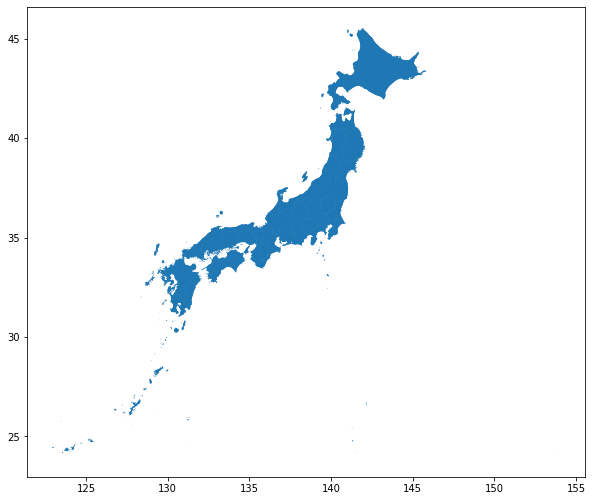

In [ ]:
ax = jpnShp.plot(figsize=(10, 10))
jpnShp.plot(ax=ax)
plt.show();

今回は都道府県レベルのデータを利用していますので、境界も描画します。加えて、名前も重畳します。

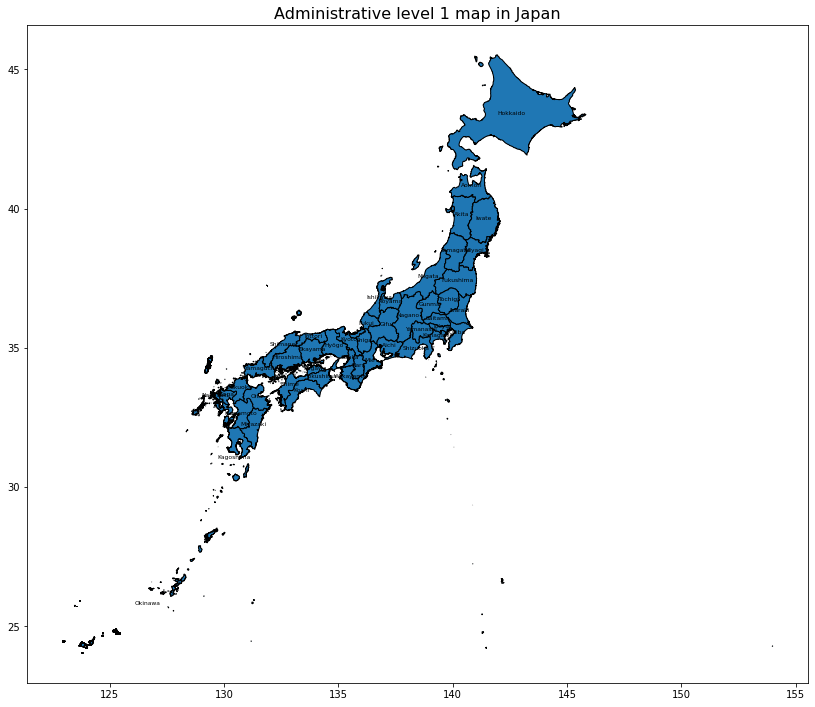

In [ ]:
# 日本のシェープデータを可視化する
ax = jpnShp.plot(figsize=(14, 14))
jpnShp.apply(lambda x: ax.annotate(s=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center', color = 'black', size = 6),axis=1)
jpnShp.plot(ax = ax, edgecolors='black')
plt.title('Administrative level 1 map in Japan', fontsize=16)
plt.show();

GeoDataFramedではShapelyとmatplotlibにより、簡単にベクターデータを可視化することができます。それでは、この図と先ほど取得したe-statのデータを結合し、さらに描画を行います。

### shpとcsvの結合

In [ ]:
# 不要な列の削除
japan = jpnShp.loc[:,['NAME_1','NL_NAME_1','geometry']].copy()

In [ ]:
combDf = japan.merge(marriageDf,left_on='NL_NAME_1',right_on='prefecture',how='left') # データの結合
combDf.head() # check

,NAME_1,NL_NAME_1,geometry,sex,prefecture,year,avgAge
0,Aichi,愛知県,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...",male,愛知県,2019,31.0
1,Aichi,愛知県,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...",male,愛知県,2018,30.9
2,Aichi,愛知県,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...",male,愛知県,2017,30.9
3,Aichi,愛知県,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...",male,愛知県,2016,30.9
4,Aichi,愛知県,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...",male,愛知県,2015,30.9


再度、描画を行います。今度は、2019年の平均初婚年齢を日本地図に重畳します。

In [ ]:
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# Yamaguchi
points = gpd.GeoSeries([Point(131.5213, 34.2797), Point(132.5213, 34.2797)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(6671) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
print(distance_meters)

92072.31426248427


In [ ]:
points = gpd.GeoSeries([Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
print(distance_meters)

84921.4496901889


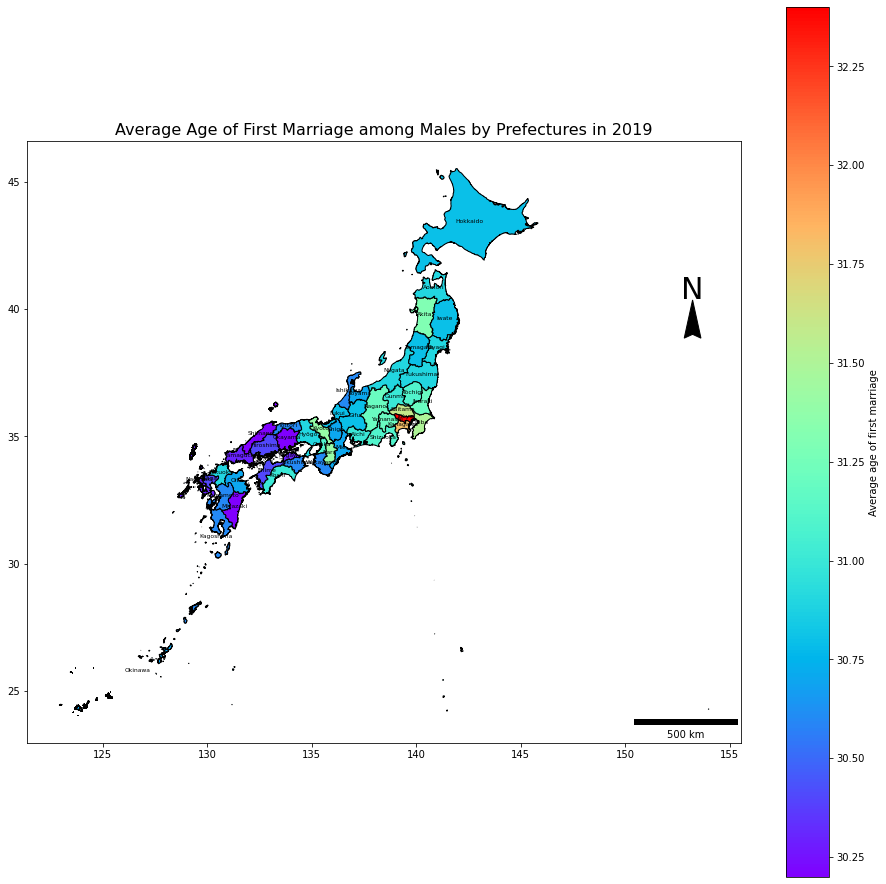

CPU times: user 2.42 s, sys: 467 ms, total: 2.89 s
Wall time: 2.42 s


In [ ]:
%%time
# 男性
# 方位の作成についての参考記事：
## https://mohammadimranhasan.com/geospatial-data-mapping-with-python/
combDf2019M = combDf.loc[(combDf.year == 2019)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
ax = combDf2019M.plot(figsize=(16, 16))
scalebar = ScaleBar(100, location='lower right',units='km')
# ax.add_artist(ScaleBar(distance_meters))
ax.add_artist(scalebar) # 200km
ax.text(x=153.215-0.55, y=40.4, s='N', fontsize=30) # North Arrow
ax.arrow(153.215, 39.36, 0, 1, length_includes_head=True,
          head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
combDf2019M.apply(lambda x: ax.annotate(s=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center', color = 'black', size = 6),axis=1)
combDf2019M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax, legend=True,legend_kwds={'label': "Average age of first marriage",'orientation': "vertical"})
plt.title('Average Age of First Marriage among Males by Prefectures in 2019', fontsize=16)
plt.show();

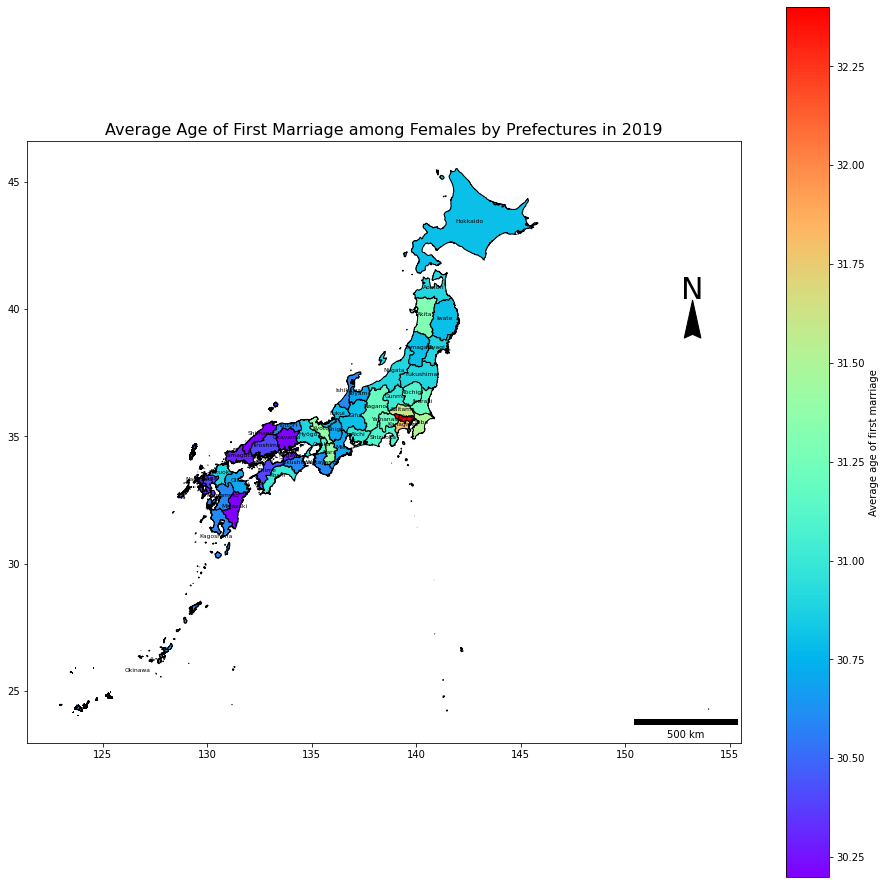

CPU times: user 2.6 s, sys: 409 ms, total: 3.01 s
Wall time: 2.65 s


In [ ]:
%%time
# 女性
combDf2019F = combDf.loc[(combDf.year == 2019)&(combDf.sex == 'female'),:].reset_index(drop=True).copy()
ax = combDf2019F.plot(figsize=(16, 16))
scalebar = ScaleBar(100, location='lower right',units='km')
ax.add_artist(scalebar) # 500km
ax.text(x=153.215-0.55, y=40.4, s='N', fontsize=30) # North Arrow
ax.arrow(153.215, 39.36, 0, 1, length_includes_head=True,
          head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
combDf2019F.apply(lambda x: ax.annotate(s=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center', color = 'black', size = 6),axis=1)
combDf2019M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax, legend=True,legend_kwds={'label': "Average age of first marriage",'orientation': "vertical"})
plt.title('Average Age of First Marriage among Females by Prefectures in 2019', fontsize=16)
plt.show();

In [ ]:
# 男性のみを抽出（4年分）
combDf2018M = combDf.loc[(combDf.year == 2018)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
combDf2017M = combDf.loc[(combDf.year == 2017)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
combDf2016M = combDf.loc[(combDf.year == 2016)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
combDf2015M = combDf.loc[(combDf.year == 2015)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()

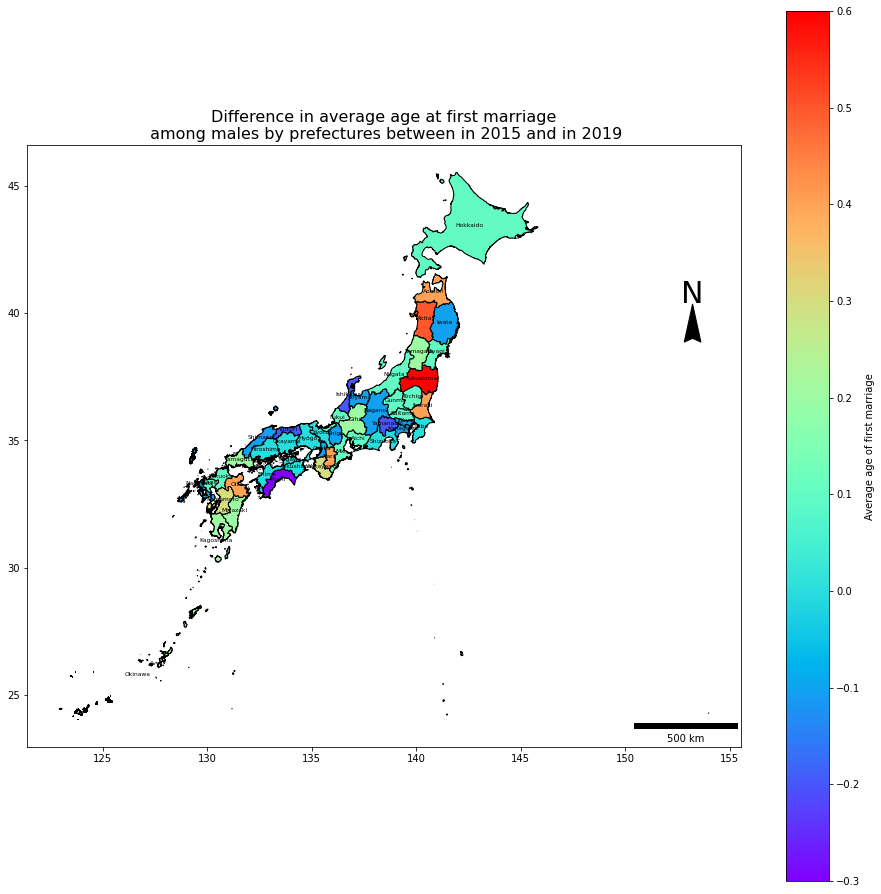

In [ ]:
combDf2019M = combDf.loc[(combDf.year == 2019)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
diffAge = pd.Series(combDf2019M.avgAge - combDf2015M.avgAge, dtype='float', name='diffAge')
# diff20152019 = pd.concat([combDf2019M, diffAge], axis=1)
combDf2019M['diffAge'] = diffAge
# 男性
# 方位の作成についての参考記事：
## https://mohammadimranhasan.com/geospatial-data-mapping-with-python/
ax = combDf2019M.plot(figsize=(16, 16))
scalebar = ScaleBar(100, location='lower right',units='km')
ax.add_artist(scalebar) # 500km
ax.text(x=153.215-0.55, y=40.4, s='N', fontsize=30) # North Arrow
ax.arrow(153.215, 39.36, 0, 1, length_includes_head=True,
          head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
combDf2019M.apply(lambda x: ax.annotate(s=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center', color = 'black', size = 6),axis=1)
combDf2019M.plot(column='diffAge', cmap = 'rainbow', edgecolors='black', ax = ax, legend=True,legend_kwds={'label': "Average age of first marriage",'orientation': "vertical"})
plt.title('Difference in average age at first marriage\n among males by prefectures between in 2015 and in 2019', fontsize=16)
plt.show();

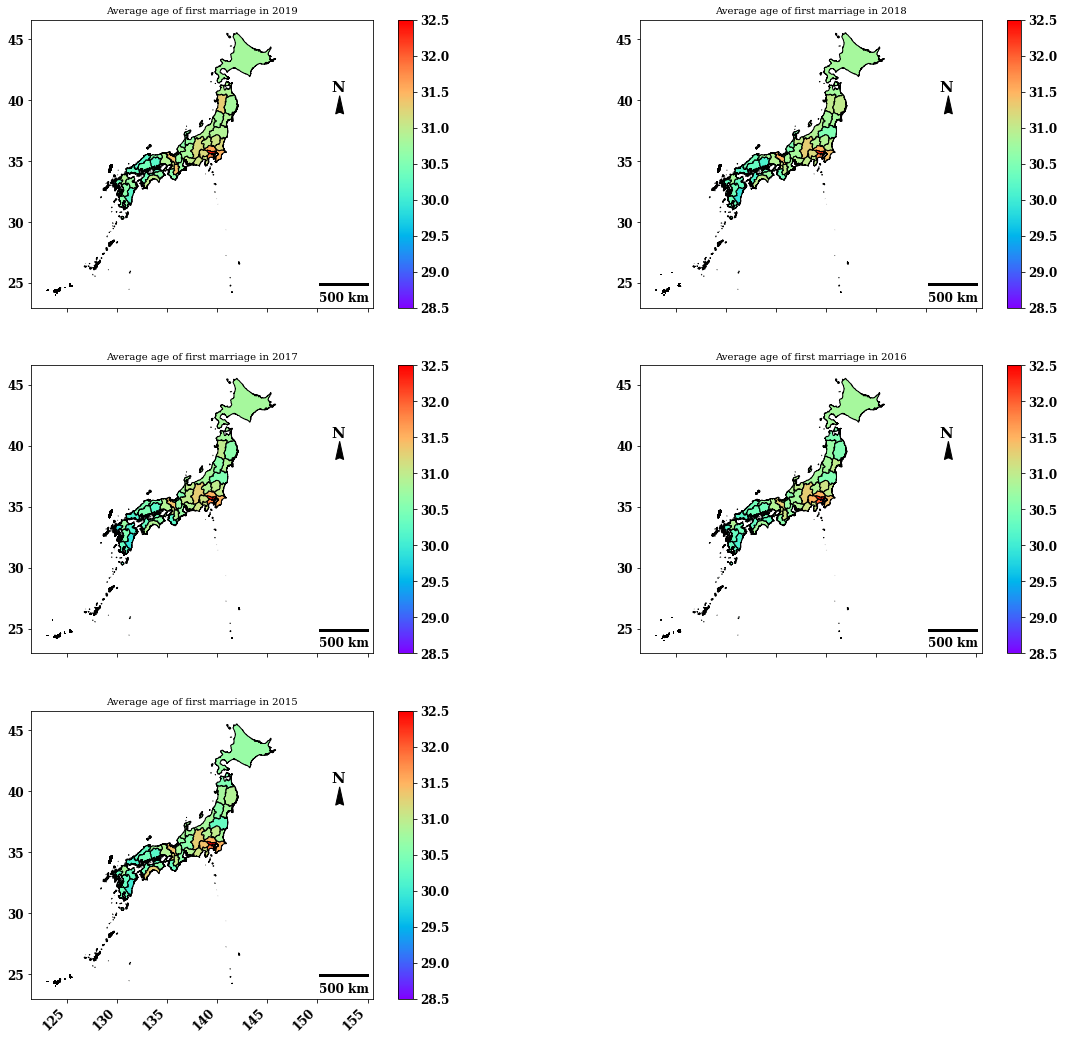

In [ ]:
with plt.rc_context(rc={'font.family': 'serif', 'font.weight': 'bold', 'font.size': 12}):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize = (20,20))
    fig.autofmt_xdate(rotation = 45)
    # 2019
    scalebar = ScaleBar(100, location='lower right',units='km')
    combDf2019M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax1, legend=True,vmin=28.5, vmax=32.5)
    ax1.set_title('Average age of first marriage in 2019', fontsize=10)
    ax1.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax1.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax1.add_artist(scalebar)
    # 2018
    scalebar = ScaleBar(100, location='lower right',units='km')
    combDf2018M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax2, legend=True,vmin=28.5, vmax=32.5)
    ax2.set_title('Average age of first marriage in 2018', fontsize=10)
    ax2.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax2.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax2.add_artist(scalebar)
    # 2017
    scalebar = ScaleBar(100, location='lower right',units='km')
    combDf2017M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax3, legend=True, vmin=28.5, vmax=32.5)
    ax3.set_title('Average age of first marriage in 2017', fontsize=10)
    ax3.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax3.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax3.add_artist(scalebar)
    # 2016
    scalebar = ScaleBar(100, location='lower right',units='km')
    combDf2016M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax4, legend=True, vmin=28.5, vmax=32.5)
    ax4.set_title('Average age of first marriage in 2016', fontsize=10)
    ax4.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax4.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax4.add_artist(scalebar)
    # 2015
    scalebar = ScaleBar(100, location='lower right',units='km')
    combDf2015M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax5, legend=True, vmin=28.5, vmax=32.5)
    ax5.set_title('Average age of first marriage in 2015', fontsize=10)
    ax5.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax5.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax5.add_artist(scalebar)
    # Blank
    ax6.axis('off')
    # plt.tight_layout(pad=4)
    plt.show();

僅かな変化は見られますが、基本的に関東地域で平均初婚年齢が高く、中国、九州地方で低いという傾向が見て取れます。

## 衛星データとの組み合わせ（ラスターデータとの組み合わせ）

ここから、

- 座標系
- ベクターデータをある範囲内で切り取る
- eeを用いた衛星データ(MOD13Q1)の読み込み
- 任意の切り取り範囲でデータを可視化する

について説明を行います。

### 座標系

ラスターデータやベクターデータが地理空間情報を含むということは、そのデータを地球上のどこかに当てはめることができるということです。そのため、これらのデータは、当てはめの基準を持っています。この基準を参照系と呼び、データは参照系に基にして、平面や球面状に表現されることになります。つまり、持っているデータが同じ日本を示していても、参照系が異なれば、異なったルールで描画されるということになります。そのため、参照系を共通のものにすることが重要になります。

先程作成したgeojsondデータを読み込み、その参照系を確認しましょう。

*正しくは、Coordinate Reference System (CRS：座標参照系と呼びます)


日本では19の平面直角座標系を設定し、狭い範囲での歪みを少なくするという方法をとっています。逆に言えば、その他の地域では歪みを許容しているということになります。

WGS 84とサンソン図法（正弦曲線図法）、そして日本の平面直角座標を比べて、歪みがどのようなものかを確かめてみましょう。

WGS 84は位置情報として用いられるもので、地球面上の対象の位置を緯度と経度で示したものです。サンソン図法では角度に歪みが出ますが、面積を正しく表現できる図法です。今回使用しているものはWorld Sinusoidalで、世界地図の描画に使われているものとなります。

In [ ]:
# 再度日本のポリゴンを読み込み
jpnShp = gpd.read_file('/content/drive/MyDrive/Sorabatake/japanSHP/gadm36_JPN_1.shp')
jpnShp.crs # 初期値はWGS 84の地理座標形

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

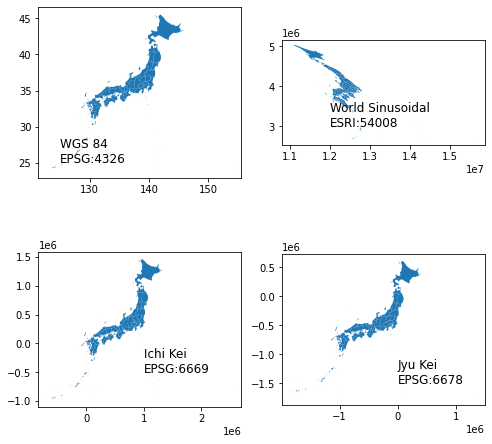

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (8,8))

jpnShp.plot(ax=ax1) # WGS 84
ax1.text(x=125, y=25, s='WGS 84\nEPSG:4326', fontsize=12)

# Convert 4326 to esri:54008
# World Sinusoidal
jpnShp.to_crs('esri:54008',inplace=True)
jpnShp.plot(ax=ax2) # 6678
ax2.text(x=12000000, y=3000000, s='World Sinusoidal\nESRI:54008', fontsize=12)

# Convert esri:54008 to 6669
# 長崎県、鹿児島県の一部に対応
jpnShp.to_crs('epsg:6669',inplace=True)
jpnShp.plot(ax=ax3) # espg 6669
ax3.text(x=1000000, y=-500000, s='Ichi Kei\nEPSG:6669', fontsize=12)

# Convert 6669 to 6678
# 青森県、秋田県、山形県、岩手県、宮城県
jpnShp.to_crs('epsg:6678',inplace=True)
jpnShp.plot(ax=ax4) # 6678
ax4.text(x=0, y=-1500000, s='Jyu Kei\nEPSG:6678', fontsize=12)

plt.show()

ここからは、具体的に参照系の変換を行なっていきます。

利用するデータは以下の通りです：

- [庄内エリアのgeojson](https://github.com/sorabatake/article_20455_geopandas/blob/master/input/shounai.geojson)
- [庄内エリアの筆ポリゴン](https://github.com/sorabatake/article_20455_geopandas/blob/master/input/062032019_5.geojson)

確認のため、foliumで簡単に場所を示してみます。

下のセルでは、geometryというメソッドを利用しています。GeoSeriesの属性はメソッドはほとんどがshapely由来のものです。


In [ ]:
# read GeoJSON
# ファイルを保存する階層に合わせて適宜パスは変更してください
shounai = gpd.read_file('/content/drive/MyDrive/Sorabatake/shounai.geojson')
shounai.head()

,geometry
0,"POLYGON ((139.80210 38.81213, 139.79218 38.810..."


In [ ]:
latlon = [shounai.geometry.centroid.y[0],shounai.geometry.centroid.x[0]] # ポリゴンの中心座標を求める

m = folium.Map(latlon, zoom_start=12, control_scale=True) # 上で求めた中心座標を中心にzoomレベル12で描画
folium.GeoJson(shounai).add_to(m) # ベースマップにshounaiのポリゴンを重ねる
m

それでは取得したデータの空間参照系を確認してみましょう。

In [ ]:
shounai.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

こちらのポリゴンデータではWGS 84という参照系が当てはめられています。地理座標系は、地球をそのまま立体と捉え（球体）、後者では球体である地球を平面に変換したものです。WGS 84は地理座標系にあたり、地球を球面として捉えています。

山形はUTM 54Nに当たるため、EPSG 6691を指定すれば良いことがわかります。

In [ ]:
# Convert 4326 to 6691
shounai.to_crs('epsg:6691',inplace=True)

In [ ]:
# Check its crs
shounai.crs

<Projected CRS: EPSG:6691>
Name: JGD2011 / UTM zone 54N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Japan - between 138°E and 144°E, onshore and offshore.
- bounds: (138.0, 17.63, 144.0, 46.05)
Coordinate Operation:
- name: UTM zone 54N
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2011
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

WGS 84からJGD 2011座標系に置き換わっているのが分かります。投影座標系はUTM 54Nになっています。（Datumというのは測地系というものです。理想的な球面である地理座標系を構築するためのベースとなっているようなものと思ってください）。

それでは、面積(ヘクタール）を計算してみましょう。

In [ ]:
shounai['area_ha'] = shounai.geometry.area/10**4
shounai.head()

,geometry,area_ha
0,"POLYGON ((395996.193 4296609.728, 395133.698 4...",172.35443


作成したポリゴンは、約172ヘクタールであることがわかりました。

### 二つのベクターデータの結合

山形県鶴岡市の筆ポリゴンを取得し、そのGeoJSONをGeoPandasで読み込みます。

筆ポリゴンは[こちら](https://niaesvic.dc.affrc.go.jp/ja/dataset/maff_fude_pref06/resource/0dd9ca28-4e2b-4034-99a1-62f2d3f9b7be)からダウンロード可能です。

In [ ]:
fudeShounai = gpd.read_file('/content/drive/MyDrive/Sorabatake/062032019_5.geojson')
fudeShounai.head()

,耕地の種類,geometry
0,畑,"POLYGON ((139.66770 38.69666, 139.66774 38.696..."
1,畑,"POLYGON ((139.63995 38.68438, 139.63997 38.684..."
2,田,"POLYGON ((139.61416 38.53564, 139.61411 38.535..."
3,畑,"POLYGON ((139.60905 38.66172, 139.60904 38.661..."
4,田,"POLYGON ((139.96073 38.66176, 139.96079 38.661..."


同様にCRSを確かめます。

In [ ]:
fudeShounai.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

耕地の種類から、畑のみを抽出します。

In [ ]:
fudeShounaiF = fudeShounai.loc[fudeShounai['耕地の種類'] == '畑',:]

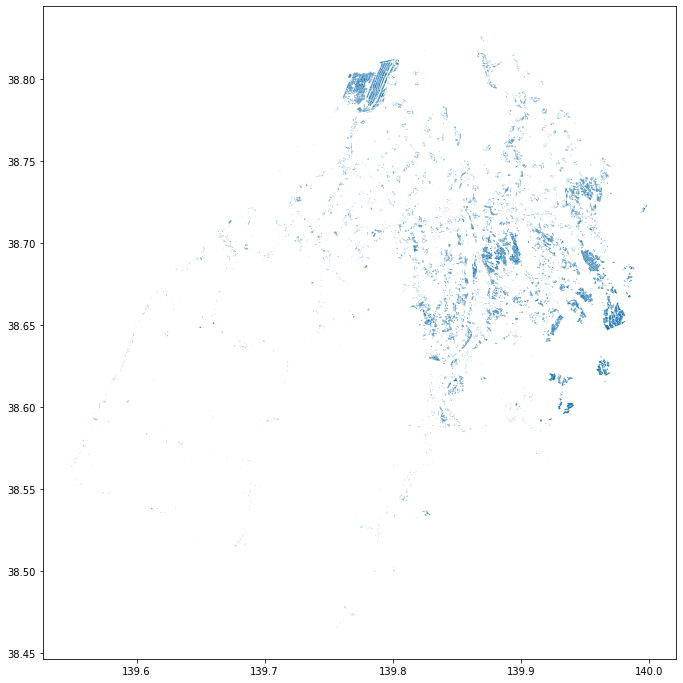

In [ ]:
fudeShounaiF.plot(figsize=(12,12))
plt.show()

鶴岡市全域の畑のポリゴンが描画できました。

座標系を変換し、こちらも面積を求めてみましょう。

In [ ]:
# Convert 4326 to 6691
fudeShounaiF.to_crs('epsg:6691',inplace=True)
fudeShounaiF.insert(1,'area_ha',fudeShounaiF.geometry.area/10**4) # ヘクタールへの変換

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
fudeShounaiF.head()

,耕地の種類,area_ha,geometry
0,畑,0.001259,"POLYGON ((384140.217 4283957.772, 384143.598 4..."
1,畑,0.001332,"POLYGON ((381707.270 4282630.742, 381708.770 4..."
3,畑,0.001430,"POLYGON ((378981.467 4280155.652, 378979.930 4..."
8,畑,0.001744,"POLYGON ((382863.495 4284297.926, 382867.634 4..."
13,畑,0.001842,"POLYGON ((382906.962 4284381.134, 382908.463 4..."


In [ ]:
# Reference about .overlay: https://atmamani.github.io/cheatsheets/open-geo/geopandas-3/
mergedGdf = gpd.overlay(shounai,fudeShounaiF,how='intersection') # 重なる部分の抽出
mergedGdf['areaIntersect'] = mergedGdf['geometry'].area/10**4

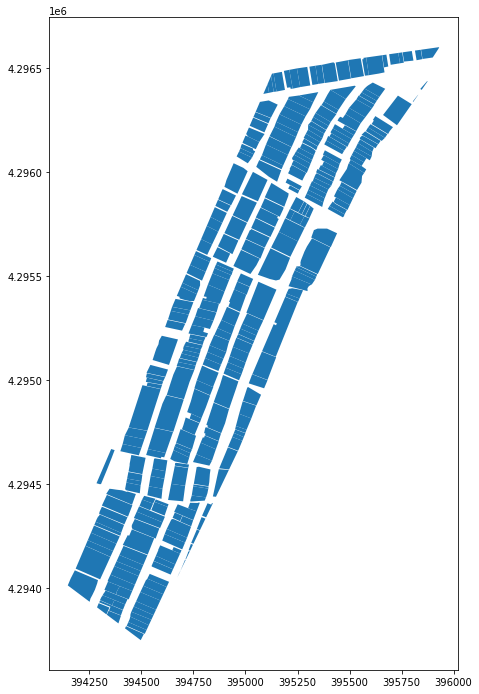

In [ ]:
mergedGdf.plot(figsize=(12,12))

先程の全域のポリゴンから、その一部を切り抜くことができました。

改めて、foliumで確認してみましょう。

In [ ]:
latlon = [38.7918,139.8118]
m = folium.Map(latlon,zoom_start=14, control_scale=True)
folium.GeoJson(mergedGdf).add_to(m)
m

作成したgeojsonの内部の畑のポリゴンのみが抽出されていることが確認できたかと思います。

In [ ]:
mergedGdf.head()

,area_ha_1,耕地の種類,area_ha_2,geometry,areaIntersect
0,172.35443,畑,0.056522,"POLYGON ((395874.936 4296435.892, 395847.288 4...",0.025816
1,172.35443,畑,0.066764,"POLYGON ((394748.834 4294490.234, 394750.422 4...",0.066764
2,172.35443,畑,0.070572,"POLYGON ((394648.011 4294182.422, 394654.785 4...",0.070572
3,172.35443,畑,0.085913,"POLYGON ((394953.900 4294779.824, 395005.212 4...",0.085913
4,172.35443,畑,0.086753,"POLYGON ((394563.159 4294415.334, 394568.911 4...",0.086753


畑のポリゴンの面積を計算しましょう。

In [ ]:
mergedGdf.areaIntersect.sum() # 合計は約108ha

108.00578337861548

結合したファイルをshpとして保存します。これは次の作業で利用します。

In [ ]:
mergedGdf.drop(columns={'area_ha_1','耕地の種類','area_ha_2'},inplace=True) # 余計な列の削除
mergedGdf.to_file("/content/drive/MyDrive/Sorabatake/merged/mergedShounai.shp") # GeoPandasをshpとして保存

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


### 衛星データの取得

最後です。上で作ったポリゴンデータを用いて、任意の範囲のみの衛星データを描画します。

今回はGoogle Earth Engineから衛星データを取得します。

取得するデータは[MODIS/Terra Vegetation Index(MOD13Q1) Version 6](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1)です。

- 16日周期で得られるデータです
- 地上分解能は250mとなります

MODISのデータは解像度は荒いですが、非常に大きな範囲を捉えています（日本であれば、h28-h29/v04-v05の3枚から4枚のタイルで覆えるくらいの大きさです)。そのため、興味のある場所で画像を切り取るのは大事な作業になります。

![modisTile](https://modis-land.gsfc.nasa.gov/images/MODIS_sinusoidal_grid1.gif)

<center>Source: National Aeronautics and Space Administration
Goddard Space Flight Center </center>

＊GEEを使う前に認証を行う必要があります。認証はGEEに登録済みのユーザーアカウントで行ってください。

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=wta-4qP4AwGH4zDFsqFf2tS4xiSeFLLKD-hMDlsKs2s&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjULSuozaWu4t4A4XA8yHvYEeW4UEJAXwSDKrRXvOuhxu9R3Fs6oxI

Successfully saved authorization token.


Successfully saved authorization token.

と出れば認証に成功です。

In [ ]:
Map = geemap.Map(center=latlon, zoom=14, control_scale=True)
fudePoly = geemap.shp_to_ee('/content/drive/MyDrive/Sorabatake/merged/mergedShounai.shp') # EPSG:4326 (Default)
# fudePolySimple = fudePoly.map(lambda feature: feature.simplify(maxError = 50))
Map.addLayer(fudePoly, {}, 'Shounai Hatake') # レイヤー名はShounai Hatake
Map

MOD13Q1からデータを取得します。Earth Engineでは、ラスターはImageCollection、ベクターはFeatureCollectionというコンストラクタ（メソッド）を用いて取得します。その名前の通り、取得するデータは全て大きなデータのまとまりになっています。

つまり、`ee.ImageCollection(...)`のようにすると、指定したデータでEarth Engineが持っている全てのデータ（アセット）を読み込むことになります。そのため、その後にデータを絞る必要があります。そこで用いられるのが、filterDateやfilterBoundsなどです。

In [ ]:
# MODISデータの読み込み
# 今回は4月から9月までの範囲でデータを取得しています。
# EPSG:4326 (Default)
modis = ee.ImageCollection('MODIS/006/MOD13Q1') # IDの指定。今回はMODIS/006/MOD13Q1
modis = modis.filterDate(ee.DateRange('2019-04-01','2019-7-01')) # 2019年4月1日から2019年7月1日を取得

MOD13Q1に含まれるバンド情報を確認します。

In [ ]:
modis.first().bandNames().getInfo()

['NDVI',
 'EVI',
 'DetailedQA',
 'sur_refl_b01',
 'sur_refl_b02',
 'sur_refl_b03',
 'sur_refl_b07',
 'ViewZenith',
 'SolarZenith',
 'RelativeAzimuth',
 'DayOfYear',
 'SummaryQA']

In [ ]:
# 今回はNDVIのみ取得
# evi = modis.select('EVI')
ndvi = modis.select('NDVI')

NDVIのみを抽出しましょう。スケーリングが必要なため関数を定義し、値を調整します。

詳しくは[公式のドキュメント](https://lpdaac.usgs.gov/products/mod13q1v006/)、Layersを開いてください。Scale Factorと書かれているところが利用する値となります。

＊衛星データはそのままの値でなく、大きさを調整する必要があるときがあります。どのくらい調整すれば良いのかを示したものがScale Factorとなります。調整する必要がない場合には、Scale Factor = 1.0となっています。

In [ ]:
# スケーリングのための関数
def scale_factor(image):
    return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

# 取得した各々のデータに対して上の関数を実行(Mapping)
# scaled_evi = evi.map(scale_factor)
scaled_ndvi = ndvi.map(scale_factor)

In [ ]:
gmap = geemap.Map(center=latlon, zoom=14, control_scale=True)
gmap.addLayer(scaled_ndvi.mean().clip(fudePoly), name='Averaged NDVI',# ４月から９月までの平均値を描画。clipでfudePoly内のピクセルだけ取得
              vis_params={'min': 0,
                         'max': 1,
                         'palette': ['red', 'yellow','green']})
gmap.addLayerControl()
gmap

仮にIpygeeが動かないという場合は、ここの部分を飛ばしても大丈夫です。データフレーム化もeeから出力されるデータを用いて作成することが可能です。

In [ ]:
# Shounai: MOD13Q1 EVI time series
shounai_ndvi = chart.Image.series(**{'imageCollection': scaled_ndvi,
                                   'region': fudePoly,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 250, # 250m
                                   'xProperty': 'system:time_start'})
shounai_ndvi.renderWidget(width='70%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [ ]:
ndviDf = shounai_ndvi.dataframe
ndviDf

,NDVI
2019-04-07,0.345055
2019-04-23,0.367099
2019-05-09,0.436428
2019-05-25,0.459266
2019-06-10,0.336532
2019-06-26,0.501812


念のために、上の方法を利用しないテーブルデータの作成方法についても言及をします。

関心領域（この場合はfudePoly）からNDVIの平均値を取得し、その日付と平均値を取得するための関数を作成します。

In [ ]:
# 関心領域のピクセルから平均値を導出
def aoi_mean(img):
  # scaleには通常、そのラスターの解像度を渡します
  # mean = img.reduceRegion(reducer=ee.Reducer.mean().unweighted(), geometry=fudePoly, scale=250).get('NDVI') # 重みなし
  # mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=fudePoly).get('NDVI') # 重みなし
  mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=fudePoly, scale=250).get('NDVI') # 重みあり
  return img.set('date', img.date().format('Y-M-d')).set('mean',mean)

reduceRegionでは、対象とする地域を絞りつつ、[reducerによる重み付け平均](https://developers.google.com/earth-engine/apidocs/ee-reducer-mean)を行っています。[ee.Reducer](https://developers.google.com/earth-engine/guides/reducers_intro)には他にも様々な種類があります。

![reduce](https://developers.google.com/earth-engine/images/Reduce_region_diagram.png)

Source: https://developers.google.com/earth-engine/guides/reducers_reduce_region

上記で得られたee.Image（各々の画像データ）に対して、メタデータを付与しています。この場合は、日付と計算した平均値です。

先ほども登場したmapですが、Earth Engineでは基本的にfor文を使うことはありません。ImageCollectionは画像データの集まりなので、気持ちとしてはこれらのデータそれぞれにfor文で上の処理を行いたいところです。しかし、Earth Engineではfor文は推奨されていません。その理由として、高度な並列処理ができなくなるからだそうです。


詳しくは、[公式の情報](https://developers.google.com/earth-engine/tutorials/tutorial_js_03)をご覧ください。

In [ ]:
ndvi_reduced_imgs = scaled_ndvi.map(aoi_mean)

In [ ]:
nested_list = ndvi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

平均値を求めたImageCollectionから、指定した列のみを抽出したい場合、reduceColumnsを利用します。[reduceColumns](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-reducecolumns)では出力は辞書型になりますので、[ee.Reducer.toList](https://developers.google.com/earth-engine/apidocs/ee-reducer-tolist)をを用いて出力をリスト型に変えています。最後に値のみを抽出し、リストの内側のみの値を取り出します。

これでデータフレームを作成する準備ができました。

In [ ]:
df = pd.DataFrame(nested_list.getInfo(), columns=['date','ndvi'])
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')

In [ ]:
df

,date,ndvi
0,2019-04-07,0.345055
1,2019-04-23,0.367099
2,2019-05-09,0.436428
3,2019-05-25,0.459266
4,2019-06-10,0.336532
5,2019-06-26,0.501812


描画を行います。

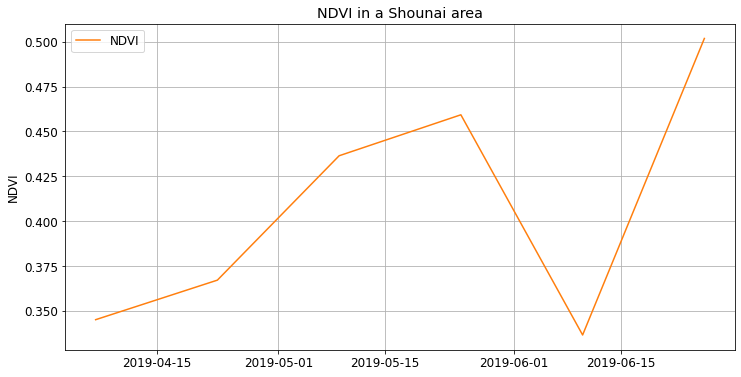

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(12, 6))

# 線の見た目調整
ax.plot(df.date, df.ndvi, color='tab:orange', label='NDVI')

# ラベルとタイトルなど
ax.set_xlabel('')
ax.set_ylabel('NDVI')
ax.set_title('NDVI in a Shounai area')
ax.grid(True)
ax.legend(loc='upper left'); # レジェンドの位置

やや面倒ですが、このような作業で自分の興味範囲のみの衛星画像データをデータフレームにすることができます。今回は筆ポリゴンの面積も求めていますので、収量予測のモデルが作れれば、面積あたりの収量を予測することも可能です。